# Testing the bell inequality for higgs boson decay
**Master Thesis 2023 Chalmers**

This notebook has been made during my master thesis to test the bell inequality for Higgs boson decay in to WW bosons at the LHC. It is mostly built on two papers:

*   https://arxiv.org/abs/2106.01377 
*   https://arxiv.org/abs/2302.00683 

All data is from the Atlas open data set for two leptons and have been filtered and put into CSV files by a seperate program. The selection criteria was taken from http://opendata.atlas.cern/release/2020/documentation/physics/DL2.html 

The equations to calculate the bell inequality in the first cell is from the first paper.

In [1]:
from google.colab import drive 
drive.mount('/content/drive')
import xgboost as xgb
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv1D
from sklearn.decomposition import PCA
import heapq
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import svm
from sklearn import metrics
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
import pickle 

def calcbell(phi1,phi2):
  Xp=np.cos(phi1)
  Yp=np.sin(phi1)
  Xm=np.cos(phi2)
  Ym=np.sin(phi2)
  
  term1=(np.multiply(Xp,Xm)+np.multiply(Yp,Ym)).flatten()
  term2=(np.multiply(np.multiply(Xp,Xp)-np.multiply(Yp,Yp),np.multiply(Xm,Xm)-np.multiply(Ym,Ym))).flatten()
  term3=np.multiply(np.multiply(Xp,Xm),np.multiply(Ym,Yp)).flatten()
  
  c1=8/np.sqrt(3)
  c2=25
  c3=100

  sum=c1*np.mean(term1)+c2*np.mean(term2)+c3*np.mean(term3)
  std=np.sqrt(c1**2*np.var(term1)+c2**2*np.var(term2)+c3**2*np.var(term3)+
  2*c1*c2*np.cov(term1,term2)[0,1]+2*c1*c3*np.cov(term1,term3)[0,1]+2*c2*c3*np.cov(term2,term3)[0,1])/np.sqrt(len(phi1))
  return [sum, std]

def calcbellvec(phi1,phi2):
  Xp=np.cos(phi1)
  Yp=np.sin(phi1)
  Xm=np.cos(phi2)
  Ym=np.sin(phi2)
  
  term1=(np.multiply(Xp,Xm)+np.multiply(Yp,Ym)).flatten()
  term2=(np.multiply(np.multiply(Xp,Xp)-np.multiply(Yp,Yp),np.multiply(Xm,Xm)-np.multiply(Ym,Ym))).flatten()
  term3=np.multiply(np.multiply(Xp,Xm),np.multiply(Ym,Yp)).flatten()
  
  c1=8/np.sqrt(3)
  c2=25
  c3=100

  sum=c1*term1+c2*term2+c3*term3
  return sum

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


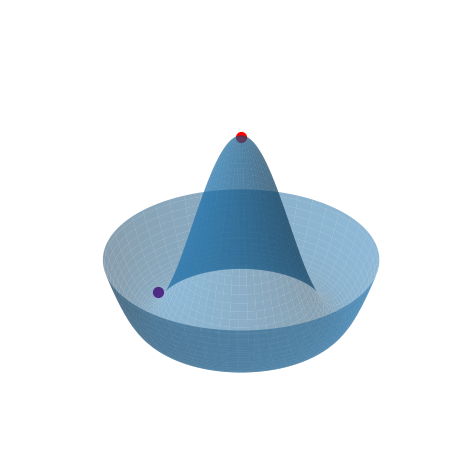

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

# Define the function for the Goldstone sombrero potential
def goldstone_sombrero(r):
    return (np.cos(r))**2 - 0.5

# Create a meshgrid of r and theta values
r = np.linspace(0, 2.2, 100)
theta = np.linspace(0, 2*np.pi, 100)
R, THETA = np.meshgrid(r, theta)

# Convert from polar coordinates to Cartesian coordinates
X = R * np.cos(THETA)
Y = R * np.sin(THETA)

# Evaluate the function on the meshgrid
Z = goldstone_sombrero(R)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the potential surface
surf = ax.plot_surface(X, Y, Z, alpha=0.5)

# Set the axis limits
ax.set_xlim([-2.2, 2.2])
ax.set_ylim([-2.2, 2.2])
ax.set_zlim([-0.5, 0.5])

# Remove the grid and axis
ax.grid(False)
ax.set_axis_off()
mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = False

# Add a ball at the top
ax.scatter(0, 0, goldstone_sombrero(0), color='red', s=50)

# Add a ball at the bottom
ax.scatter(-np.pi/2,0, goldstone_sombrero(np.pi/2), color='purple', s=50)

# Set the axis labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Potential')
#ax.set_title('Goldstone Sombrero Potential')

# Show the plot
fig.tight_layout()
plt.savefig('SSP.pdf', format='pdf',transparent=True)
plt.show()

<ipython-input-1-d3dad715453d>:36: RuntimeWarning: Degrees of freedom <= 0 for slice
  2*c1*c2*np.cov(term1,term2)[0,1]+2*c1*c3*np.cov(term1,term3)[0,1]+2*c2*c3*np.cov(term2,term3)[0,1])/np.sqrt(len(phi1))


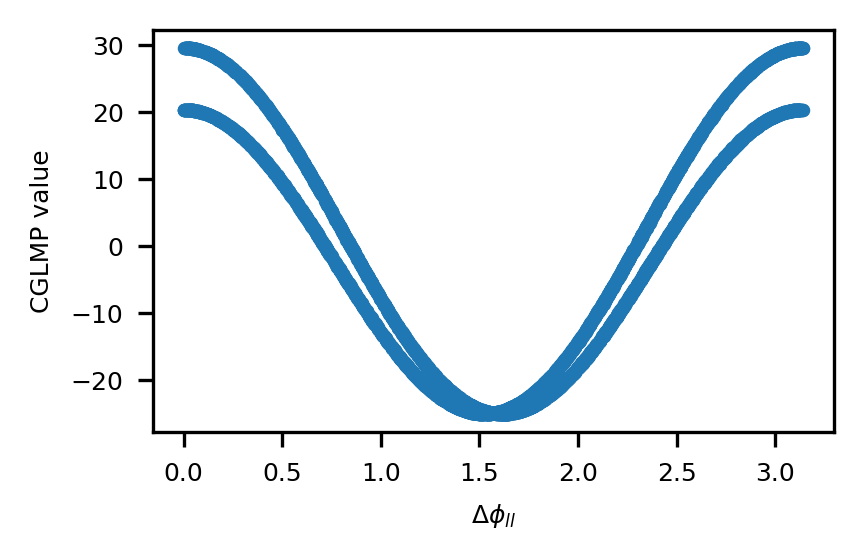

In [51]:
N=5000
fig,ax = plt.subplots(dpi=300)

phi1=np.random.uniform(low=-3.14,high=3.14,size=(N,1))
phi2=np.random.uniform(low=-3.14,high=3.14,size=(N,1))
dphi=phi1-phi2
for i in range(N):
  if dphi[i]>3.14:
    dphi[i]-=3.14
  if dphi[i]<0:
    dphi[i]+=3.14

bell=[]

for i in range(N):
  if dphi[i]>3.14:
    dphi[i]-=3.14
  if dphi[i]<0:
    dphi[i]+=3.14
  bell.append(calcbell(phi1[i],phi2[i])[0])
plt.rcParams.update({'font.size' : 6})
plt.ylabel('CGLMP value', fontsize=6)
plt.xlabel('$\Delta \phi_{ll}$', fontsize=6)

plt.scatter(dphi,bell, s=5)
plt.tight_layout()
fig.set_figwidth(2.5)
fig.set_figheight(1.5)
plt.show();

**Custom Loss function**

Since it was more or less imposible to perfectly classify the H-->WW events a custom loss function was used to decrease the falsely positive events. The constant in front of the "precision" term is just tested emperically to give the best results. Be cautious of setting it to high since the model will clasify all events as background

In [ ]:
#fungerande costum loss
def custom_loss(y, y_pred):
    """
    Parameters
    # ----------
    y_pred   : predicted values for a batch if samples (should, are not be binary: 0 or 1)
    y   : correct values for the set of samples used (must be binary: 0 or 1)
    Returns
    -------
    out : the special loss
    """
    FP = tf.math.logical_and(tf.cast(y, tf.float32) == 0, tf.cast(y_pred, tf.float32) > 0.5)
    TP = tf.math.logical_and(tf.cast(y, tf.float32) == 1, tf.cast(y_pred, tf.float32) > 0.5)
    FPs = tf.math.reduce_sum(tf.cast(FP,tf.float32)*y_pred)
    FN = tf.math.logical_and(tf.cast(y, tf.float32) == 1, tf.cast(y_pred, tf.float32) < 0.5)

    Precision = FPs /(tf.math.reduce_sum(tf.cast(TP,tf.float32))+1e-3)#tf.math.reduce_sum(tf.cast(FP,tf.float32))+
    return 0.05*Precision+tf.keras.losses.BinaryCrossentropy()(y, y_pred)#165

Data is imported from the CSV file, due to some problems in the filtering there is a small number of duplicates that has to be dropped and there is also a few (>100) events that is outliars that makes the data hard to visualise that is dropped. From the header list you can see which column is what. Three jets were selected since only a few events has more. If a event has fewer jets the rest is set to zeros.

In [2]:
headerList = ["mLL", "ptLL", "dPhi_LL", "dPhiLLmet", "MET", "mt", "jet_n", "goodjet_n", "goodbjet_n",
              "Pt1", "Eta1", "E1", "Phi1", "lep_charge1", "lep_type1", "lep_trackd0pvunbiased1", "lep_tracksigd0pvunbiased1", "lep_z01", "lep_ptcone301", "lep_etcone201", 
              "Pt2", "Eta2", "E2", "Phi2", "lep_charge2", "lep_type2", "lep_trackd0pvunbiased2", "lep_tracksigd0pvunbiased2", "lep_z02", "lep_ptcone302", "lep_etcone202", 
              "jeteta0", "jetMV2c100", "jetjvt0", "jetpt0", "jetphi0", "jetE0", "jeteta1", "jetMV2c101", "jetjvt1", "jetpt1", "jetphi1", "jetE1", "jeteta2", "jetMV2c102", "jetjvt2", "jetpt2", "jetphi2", "jetE2", "target"]
df=pd.read_csv('drive/My Drive/MC.csv', delimiter='\t', names=headerList)
#df=df.drop_duplicates()
df=df.loc[(df['ptLL']<400) & (df['MET']<600)& (df['Pt1']<150000) & (df['Pt2']<500000) & (df['MET']<250000) & (df['E1']<1000) & (df['lep_etcone201']>-10000) & (df['lep_tracksigd0pvunbiased1']<50) & (np.abs(df['lep_trackd0pvunbiased1'])<0.4) & (df['lep_tracksigd0pvunbiased1']<30) 
& (np.abs(df['lep_z01'])<2) & (df['lep_ptcone301']<10000) & (df['E2']<400) & (np.abs(df['lep_trackd0pvunbiased2'])<0.5) & (df['lep_tracksigd0pvunbiased2']<45) & (df['lep_ptcone302']<6000) & (np.abs(df['lep_etcone202'])<5000) & (df['jetpt1']<35000)]#ta bort sjuka outliars
df.to_numpy()
df=np.asarray(df)
print('antal sample '+str(len(df))) 
print('antal H-->WW '+str(int(np.sum(df[:,-1])))) 
print('H-->WW procentuellt '+str(int(100*np.sum(df[:,-1])/len(df)))+'%') 

antal sample 845340
antal H-->WW 250103
H-->WW procentuellt 29%


In [ ]:
headerList = ["mLL", "ptLL", "dPhi_LL", "dPhiLLmet", "MET", "mt", "jet_n", "goodjet_n", "goodbjet_n",
              "Pt1", "Eta1", "E1", "Phi1", "lep_charge1", "lep_type1", "lep_trackd0pvunbiased1", "lep_tracksigd0pvunbiased1", "lep_z01", "lep_ptcone301", "lep_etcone201", 
              "Pt2", "Eta2", "E2", "Phi2", "lep_charge2", "lep_type2", "lep_trackd0pvunbiased2", "lep_tracksigd0pvunbiased2", "lep_z02", "lep_ptcone302", "lep_etcone202", 
              "jeteta0", "jetMV2c100", "jetjvt0", "jetpt0", "jetphi0", "jetE0", "jeteta1", "jetMV2c101", "jetjvt1", "jetpt1", "jetphi1", "jetE1", "jeteta2", "jetMV2c102", "jetjvt2", "jetpt2", "jetphi2", "jetE2", "target"]
df_new=pd.read_csv('drive/My Drive/new.csv', delimiter='\t', names=headerList)
#df=df.drop_duplicates()
df_new=df_new.loc[(df_new['ptLL']<400) & (df_new['MET']<600)& (df_new['Pt1']<150000) & (df_new['Pt2']<500000) & (df_new['MET']<250000) & (df_new['E1']<1000) & (df_new['lep_etcone201']>-10000) & (df_new['lep_tracksigd0pvunbiased1']<50) & (np.abs(df_new['lep_trackd0pvunbiased1'])<0.4) & (df_new['lep_tracksigd0pvunbiased1']<30) 
& (np.abs(df_new['lep_z01'])<2) & (df_new['lep_ptcone301']<10000) & (df_new['E2']<400) & (np.abs(df_new['lep_trackd0pvunbiased2'])<0.5) & (df_new['lep_tracksigd0pvunbiased2']<45) & (df_new['lep_ptcone302']<6000) & (np.abs(df_new['lep_etcone202'])<5000) & (df_new['jetE2']<175000) & (df_new['jetpt1']<30000) & (df_new['jetpt2']<30000)]#ta bort sjuka outliars
df_new.to_numpy()
df_new=np.asarray(df_new)
dftot=np.concatenate((df, df_new))
print('antal sample '+str(len(dftot))) 
print('antal H-->WW '+str(int(np.sum(dftot[:,-1])))) 
print('H-->WW procentuellt '+str(int(100*np.sum(dftot[:,-1])/len(dftot)))+'%') 

antal sample 1411161
antal H-->WW 815924
H-->WW procentuellt 57%


In [ ]:
shift=np.random.uniform(0,np.pi/2)
dfcp=np.copy(dftot)
dfcp[:,17]*=-1
dfcp[:,28]*=-1
dfcp[:,12]+=shift
dfcp[:,23]+=shift
dfcp[:,35]+=shift
dfcp[:,41]+=shift
dfcp[:,47]+=shift
dfcp[:,12]-=(dfcp[:,12]>np.pi)*2*np.pi
dfcp[:,23]-=(dfcp[:,23]>np.pi)*2*np.pi
dfcp[:,35]-=(dfcp[:,35]>np.pi)*2*np.pi
dfcp[:,41]-=(dfcp[:,41]>np.pi)*2*np.pi
dfcp[:,47]-=(dfcp[:,47]>np.pi)*2*np.pi

dftot=np.concatenate((dftot, dfcp))

The data from the events that can be used for classification is selected and shuffeled to make the order not have any effect in the batch normalization later. Some large data is logged and then rescaled by 
\begin{equation}\frac{x-\mu}{\sigma}\end{equation} 
thereby setting all means to zero and all variances to 1 to simplify for the network. 

The logging of the data does not make a big differance and can therefore be commented out.

In [15]:
sel=np.arange(0,len(headerList)-1)
np.random.shuffle(dftot)
target=dftot[:,-1]
data=dftot[:,sel]

for i in range(len(sel)): data[:,i]=(data[:,i]-np.mean(data[:,i]))/np.std(data[:,i]) 

1.333681535875541

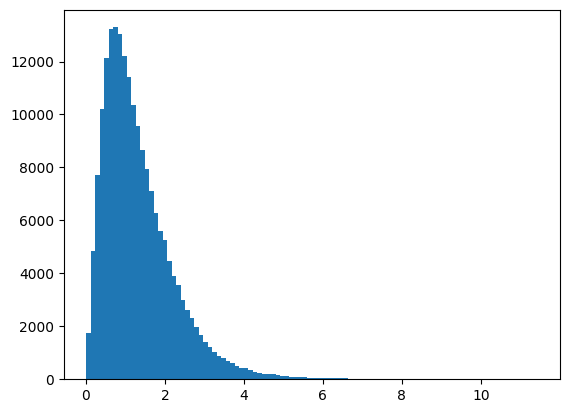

In [40]:
headerList[22]

lista=np.sqrt(((df[:,4]+df[:,11]+df[:,22])*target)**2)
lista=lista[lista>=124]
lista=np.sqrt(lista**2-124**2)/124
plt.hist(lista, bins=100)
np.mean(lista)

In [39]:
q=1.6*10**-19
m=125*10**9
Etot=165*10**9
c=3*10**8
Gevtokg=1.78266192*10**-27
m=m*Gevtokg
Ek=Etot-m*c**2
np.sqrt(Ek*2/m)

128276.23806010463

In [ ]:
np.savetxt('data.dat',data)
np.savetxt('target.dat',target)

***visualization of data***

Here one can visualize the data to see any correlation between the features and how the targeted H-->WW differances form the background.

If you want to see the unscaled data, change from "data" to "df"

goodjet_n


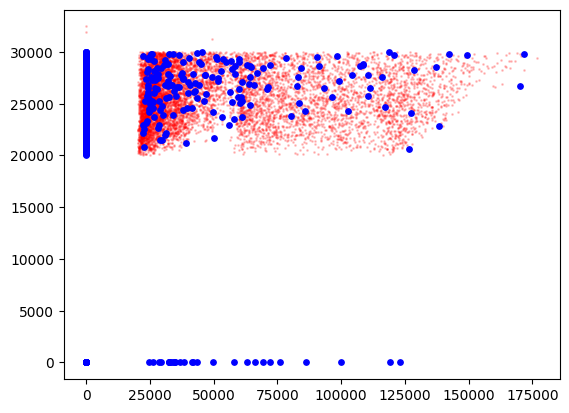

In [ ]:
plt.figure(2)
print(headerList[7]) #48 är högsta data pt1, pt2 40,46, eta1 37
col1=48
col2=40
#plt.scatter(np.extract(target==0,df[:,col1]),np.extract(target==0,df[:,col2]),color='b', s=1, alpha=0.2)
plt.scatter(np.extract(target==1,dfold[:,col1]),np.extract(target==1,dfold[:,col2]),color='r', s=1, alpha=0.2);
plt.scatter(df[:,col1],df[:,col2],color='b', s=15, alpha=1);

**PCA**

Since some of the data is correlated it can be projected down from 49 dimensions to 40 dimensions without loosing information. To be able to visualize the data is 2D you can set the N_components to 2. Note that you might need some rescaling before since some data (mostly jets) are very spread out since most events are zero. 

The plot shows how much of the variance that is explained from the different components.

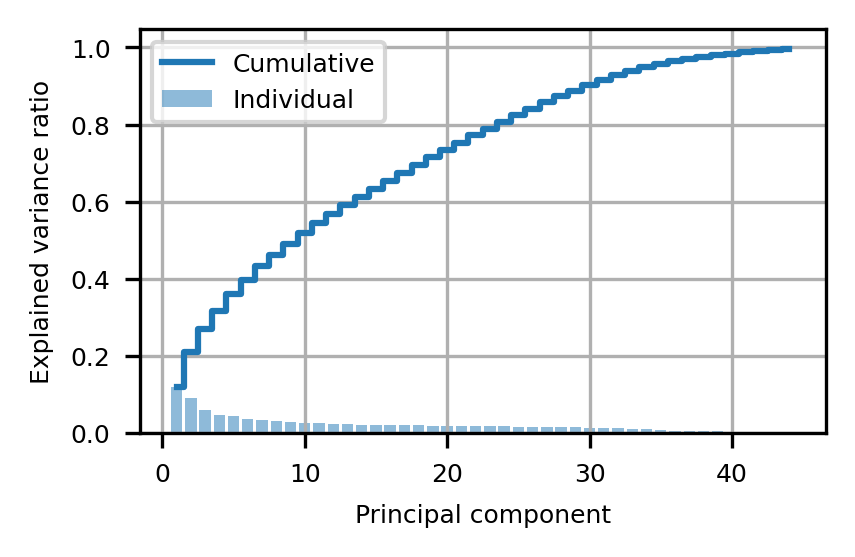

In [ ]:
#PCA
fig,ax = plt.subplots(dpi=300)
s = 6
plt.rcParams.update({'font.size' : 6})
pca = PCA(n_components=44)#set to: n_components=2 to visualize in 2d
dataPCA = pca.fit_transform(data)
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot

plt.bar(range(1,len(exp_var_pca)+1), exp_var_pca, alpha=0.5, align='center', label='Individual')
plt.step(range(1,len(cum_sum_eigenvalues)+1), cum_sum_eigenvalues, where='mid',label='Cumulative')
plt.ylabel('Explained variance ratio', fontsize=s)
plt.xlabel('Principal component', fontsize=s)
plt.legend(loc='best', fontsize=s)
plt.grid(True)
plt.tight_layout()
fig.set_figwidth(2.5)
fig.set_figheight(1.5)
plt.show()

In [ ]:
plt.subplot(2,1,1)
plt.scatter(np.extract(target==1,dataPCA[:,0]),np.extract(target==1,dataPCA[:,1]),  s=0.3, alpha=0.05, color='red')
plt.scatter(np.extract(target==0,dataPCA[:,0]),np.extract(target==0,dataPCA[:,1]),  s=0.3, alpha=0.05, color='blue')

plt.subplot(2,1,2)
plt.scatter(np.extract(target==0,dataPCA[:,0]),np.extract(target==0,dataPCA[:,1]),  s=0.3, alpha=0.05, color='blue')
plt.scatter(np.extract(target==1,dataPCA[:,0]),np.extract(target==1,dataPCA[:,1]),  s=0.3, alpha=0.05, color='red')

*IF USING PCA AND DNN*

Splitting up and packaging the data for training and testing. 

30 Epochs is enough to just see the general behaviour but 100 is the best to see good results

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataPCA, target, test_size=0.01, random_state=42)
train_dataset=tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset=tf.data.Dataset.from_tensor_slices((X_test, y_test))
train_dataset = train_dataset.batch(100)
test_dataset = test_dataset.batch(100)
epoch=50

In [ ]:
filepathDNN = '/content/drive/My Drive/best1000-8-0.01_0.05loss_large_7.hdf5' #to use old model
modelDNN = keras.models.load_model(filepathDNN, custom_objects={'custom_loss': custom_loss})
filepath1Dconv = '/content/drive/My Drive/ordered_1Dcov_3_0.00005_0.05loss_0.2drop_extracomplex_large.hdf5' #to use old model
model1Dconv = keras.models.load_model(filepath1Dconv, custom_objects={'custom_loss': custom_loss})
#SVCfilename="/content/drive/My Drive/SVC_50000_large.pickle"
#clf = pickle.load(open(SVCfilename, "rb"))

rond=0.5 #runda den lilla delen som är kontirnuelig
outputDNN=np.floor((modelDNN.predict(X_test)/rond).clip(min=0, max=1))
output1Dconv=np.floor((model1Dconv.predict(X_test1Dconv)/rond).clip(min=0, max=1))
y_pred=output1Dconv*outputDNN
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))

265/265 [==============================] - 5s 2ms/step
Accuracy: 0.7808138159451148
Precision: 0.6972205795387345


***DNN***

8 layers of 500 neurons with dropout to decrease overfitting, if dropout is set to 0 the network kan overfit to 99% in about 100 epochs. 

Hard sigmoid and sigmoid is the only activations i have got to work in the final layer

**N.B GPU is needed for training**

In [ ]:
Neuron=1000
drop=0.05

model = tf.keras.models.Sequential([ 
    tf.keras.layers.InputLayer(input_shape=(dataPCA.shape[1])), #lägga loop för att lägga till lager?
    tf.keras.layers.BatchNormalization(),#bra för overfitting
    tf.keras.layers.Dropout(drop),
    tf.keras.layers.Dense(Neuron,  activation='relu'),#1 hidden
    tf.keras.layers.Dropout(drop),
    tf.keras.layers.Dense(Neuron,  activation='relu'),#2 hidden
    tf.keras.layers.Dropout(drop),
    tf.keras.layers.Dense(Neuron,  activation='relu'),#3 hidden kernel_regularizer=tf.keras.regularizers.l2(0.0001),
    tf.keras.layers.Dropout(drop),
    tf.keras.layers.Dense(Neuron,  activation='relu'),#4 hidden
    tf.keras.layers.Dropout(drop),
    tf.keras.layers.Dense(Neuron,  activation='relu'),#5 hidden
    tf.keras.layers.Dropout(drop),
    tf.keras.layers.Dense(Neuron,  activation='relu'),#6 hidden
    tf.keras.layers.Dropout(drop),
    tf.keras.layers.Dense(Neuron,  activation='relu'),#7 hidden
    tf.keras.layers.Dropout(drop),
    tf.keras.layers.Dense(Neuron,  activation='relu'),#8 hidden    
    tf.keras.layers.Dropout(drop),

  tf.keras.layers.Dense(1, activation='hard_sigmoid')
])

model.compile(optimizer=keras.optimizers.experimental.Adam(learning_rate=0.0001),
              loss=custom_loss,#custom_loss,#tf.keras.losses.BinaryCrossentropy()
              metrics=['BinaryAccuracy' ,'Precision'])

*IF USING 1D convoluted network*

The elements that is important to each other is put into three different vectors. No big differance was found between random elements in each vector, or hand picked. 

Vector one: lepton data

Vector two: jet data

Vector three: the rest that is not as tied to any of them like missing energy, invariant mass etc.

Then splitted up and batched, at least 15 epochs is needed and no more effect after around 50

In [ ]:
newdata=data.copy()
newdataraw=np.c_[newdata, np.zeros((len(newdata[:,1]),1))]
newdata=np.c_[newdata, np.zeros((len(newdata[:,1]),1))]

div5plus0=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
div5plus1=[1, 6, 11, 16, 21, 26, 31, 36, 41, 46]
div5plus2=[2, 7, 12, 17, 22, 27, 32, 37, 42, 47]
div5plus3=[3, 8, 13, 18, 23, 28, 33, 38, 43, 48]
div5plus4=[4, 9, 14, 19, 24, 29, 34, 39, 44, 49]


sel_chanal_1=[0, 1, 2, 3, 4, 5, 6, 7, 8, 30]
sel_chanal_2=[9, 10, 11, 12, 13, 14, 15, 16,17, 18]
sel_chanal_3=[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
sel_chanal_4=[31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
sel_chanal_5=[41, 42, 43, 44, 45, 46, 47, 48, 49, 19]

#all_chanal=np.arange(0,49)
#np.random.shuffle(all_chanal)
#sel_chanal_1=all_chanal[0:int(len(all_chanal)/3)]
#sel_chanal_2=all_chanal[int(len(all_chanal)/3):2*int(len(all_chanal)/3)]
#sel_chanal_3=all_chanal[2*int(len(all_chanal)/3):3*int(len(all_chanal)/3)]

#np.random.shuffle(sel_chanal_1)
#np.random.shuffle(sel_chanal_2)
#np.random.shuffle(sel_chanal_3)
newdata[:,div5plus0] = newdataraw[:,sel_chanal_1]
newdata[:,div5plus1] = newdataraw[:,sel_chanal_2]
newdata[:,div5plus2] = newdataraw[:,sel_chanal_3]
newdata[:,div5plus3] = newdataraw[:,sel_chanal_4]
newdata[:,div5plus4] = newdataraw[:,sel_chanal_5]

newdata=newdata.reshape(-1,10,5)
X_train, X_test, y_train, y_test = train_test_split(newdata, target, test_size=0.01, random_state=42)
train_dataset=tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset=tf.data.Dataset.from_tensor_slices((X_test, y_test))
train_dataset = train_dataset.batch(100)
test_dataset = test_dataset.batch(100)
epoch=30

Check what is in each vector and in what order below

In [ ]:
import numpy as np
headerList = ["mLL", "ptLL", "dPhi_LL", "dPhiLLmet", "MET", "mt", "jet_n", "goodjet_n", "goodbjet_n",
              "Pt1", "Eta1", "E1", "Phi1", "lep_charge1", "lep_type1", "lep_trackd0pvunbiased1", "lep_tracksigd0pvunbiased1", "lep_z01", "lep_ptcone301", "lep_etcone201", 
              "Pt2", "Eta2", "E2", "Phi2", "lep_charge2", "lep_type2", "lep_trackd0pvunbiased2", "lep_tracksigd0pvunbiased2", "lep_z02", "lep_ptcone302", "lep_etcone202", 
              "jeteta0", "jetMV2c100", "jetjvt0", "jetpt0", "jetphi0", "jetE0", "jeteta1", "jetMV2c101", "jetjvt1", "jetpt1", "jetphi1", "jetE1", "jeteta2", "jetMV2c102", "jetjvt2", "jetpt2", "jetphi2", "jetE2", "target"]
headerList = np.array(headerList[:49], dtype='str')
headerList=np.append(headerList,"empty")
newlist=headerList.copy()

div5plus0=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
div5plus1=[1, 6, 11, 16, 21, 26, 31, 36, 41, 46]
div5plus2=[2, 7, 12, 17, 22, 27, 32, 37, 42, 47]
div5plus3=[3, 8, 13, 18, 23, 28, 33, 38, 43, 48]
div5plus4=[4, 9, 14, 19, 24, 29, 34, 39, 44, 49]

sel_chanal_1=[0, 1, 2, 3, 4, 5, 6, 7, 8, 30]
sel_chanal_2=[9, 10, 11, 12, 13, 14, 15, 16,17, 18]
sel_chanal_3=[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
sel_chanal_4=[31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
sel_chanal_5=[41, 42, 43, 44, 45, 46, 47, 48, 49, 19]

newlist[div5plus0] = headerList[sel_chanal_1]
newlist[div5plus1] = headerList[sel_chanal_2]
newlist[div5plus2] = headerList[sel_chanal_3]
newlist[div5plus3] = headerList[sel_chanal_4]
newlist[div5plus4] = headerList[sel_chanal_5]

newlist = newlist.reshape(10,5)
print('part1: '+str(newlist[:,0]))
print('part2: '+str(newlist[:,1]))
print('part3: '+str(newlist[:,2]))
print('part4: '+str(newlist[:,3]))
print('part5: '+str(newlist[:,4]))

part1: ['mLL' 'ptLL' 'dPhi_LL' 'dPhiLLmet' 'MET' 'mt' 'jet_n' 'goodjet_n'
 'goodbjet_n' 'lep_etcone202']
part2: ['Pt1' 'Eta1' 'E1' 'Phi1' 'lep_charge1' 'lep_type1'
 'lep_trackd0pvunbiased1' 'lep_tracksigd0pvunbiased1' 'lep_z01'
 'lep_ptcone301']
part3: ['Pt2' 'Eta2' 'E2' 'Phi2' 'lep_charge2' 'lep_type2'
 'lep_trackd0pvunbiased2' 'lep_tracksigd0pvunbiased2' 'lep_z02'
 'lep_ptcone302']
part4: ['jeteta0' 'jetMV2c100' 'jetjvt0' 'jetpt0' 'jetphi0' 'jetE0' 'jeteta1'
 'jetMV2c101' 'jetjvt1' 'jetpt1']
part5: ['jetphi1' 'jetE1' 'jeteta2' 'jetMV2c102' 'jetjvt2' 'jetpt2' 'jetphi2'
 'jetE2' 'empty' 'lep_etcone201']


Build the 1D convoluted network

In [ ]:
model = keras.models.Sequential()
drop=0.2
model.add(Conv1D(128, kernel_size=3, activation='relu', input_shape=(10,5)))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(Conv1D(256, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(drop))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00005),
              loss=custom_loss,
              metrics=['BinaryAccuracy', 'Precision'])

In [ ]:
model = keras.models.Sequential()
drop=0.3
model.add(Conv1D(256, kernel_size=3, activation='relu', input_shape=(13,3)))
#model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(Conv1D(512, kernel_size=3, activation='relu'))
#model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
#model.add(tf.keras.layers.Dropout(drop))
model.add(tf.keras.layers.Dense(64, activation='relu'))
#model.add(tf.keras.layers.Dropout(drop))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00005),
              loss=custom_loss,
              metrics=['BinaryAccuracy', 'Precision'])

In [ ]:
filepathDNN = '/content/drive/My Drive/best1000-8-0.01_0.05loss_large_7.hdf5' #to use old model
modelDNN = keras.models.load_model(filepathDNN, custom_objects={'custom_loss': custom_loss})
filepath1Dconv = '/content/drive/My Drive/ordered_1Dcov_3_0.00005_0.05loss_0.2drop_extracomplex_large.hdf5' #to use old model
model1Dconv = keras.models.load_model(filepath1Dconv, custom_objects={'custom_loss': custom_loss})
#SVCfilename="/content/drive/My Drive/SVC_50000_large.pickle"
#clf = pickle.load(open(SVCfilename, "rb"))

rond=0.5 #runda den lilla delen som är kontirnuelig
outputDNN=np.floor((modelDNN.predict(dataPCA)/rond).clip(min=0, max=1)).flatten()
output1Dconv=np.floor((model1Dconv.predict(newdata)/rond).clip(min=0, max=1)).flatten()
output=output1Dconv*outputDNN
dataPCA=dataPCA[output==1,:]
target=np.extract(output==1,target)
X_train, X_test, y_train, y_test = train_test_split(dataPCA, target, test_size=0.1, random_state=42)

 2196/26417 [=>............................] - ETA: 1:27

KeyboardInterrupt: ignored

In [ ]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train, verbose=1)
y_pred = model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))

Accuracy: 0.7035199904380566
Precision: 0.7151804539253379


Train the model and save the model from the epoch with lowest validation loss to make sure the best model is saved even if you start to overfit.

In [ ]:
filepath = '/content/drive/My Drive/DNN_balanced_8layers_1000neurons_0001learning.hdf5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, \
                              save_best_only=True, save_weights_only=False, \
                             mode='auto', save_frequency=1)

history = model.fit(train_dataset, epochs=25, validation_data = test_dataset, callbacks=[checkpoint], verbose=2);

Epoch 1/25

Epoch 1: val_loss improved from inf to 0.28789, saving model to /content/drive/My Drive/DNN_balanced_8layers_1000neurons_0001learning.hdf5
27941/27941 - 4707s - loss: 0.3182 - binary_accuracy: 0.8558 - precision: 0.9115 - val_loss: 0.2879 - val_binary_accuracy: 0.8679 - val_precision: 0.9158 - 4707s/epoch - 168ms/step
Epoch 2/25


In [ ]:
simplefilter("ignore", category=ConvergenceWarning)
#Create a svm Classifier
clf = svm.SVC(kernel='rbf', max_iter=50000) # sigmoid Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)
SVCfilename="/content/drive/My Drive/SVC_filtered_large.pickle"
pickle.dump(clf, open(SVCfilename, "wb"))

  #Predict the response for test dataset
y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))

Accuracy: 0.7112293073567203
Precision: 0.7112293073567203


Plot the evolution of the model in terms of Binary accuracy (purple, left axis) and precision (blue, right axis). 

The dashed line is training and the dotted is validation

In [ ]:
#MSE vs epoch plots
epochs = range(25)
fig,ax = plt.subplots(dpi=300)
s=12
plt.rcParams.update({'font.size' : 12})
ax2 = ax.twinx()
ax.yaxis.label.set_color('m')
ax.tick_params(axis='y', colors='m')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y', colors='b')

ax2.plot(epochs,history.history['precision'],label='Trainingdata', linestyle='dashed', color='b')
ax2.plot(epochs,history.history['val_precision'],label='Validationdata', linestyle='dotted' , color='b')

ax.plot(epochs,history.history['binary_accuracy'],label='Trainingdata', linestyle='dashed', color='m')
ax.plot(epochs,history.history['val_binary_accuracy'],label='Validationdata', linestyle='dotted', color='m')
#plt.yscale('log')
ax.set_xlabel('Epochs', fontsize=s)
ax.set_ylabel('Binary Accuracy', fontsize=s)
ax2.set_ylabel('Precision', fontsize=s)
ax2.spines['left'].set_color('m') 
ax2.spines['right'].set_color('b') 

#ax.axis([0,25,0.75,0.8])#zoom in
#ax2.axis([0,25,0.65,0.7])

plt.tight_layout()
fig.set_figwidth(2.5)
fig.set_figheight(1.5)

plt.show()

Calculating the bell inequality for the selected events for simulated data, just the selected Higgs events, just the selected background events to compare. 

Only parameter is the rounding "rond" of how the small fraction of events classified between 0 and 1 should be rounded.

In [ ]:
newdata=data.copy()
newdataraw=np.c_[newdata, np.zeros((len(newdata[:,1]),1))]
newdata=np.c_[newdata, np.zeros((len(newdata[:,1]),1))]

div5plus0=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
div5plus1=[1, 6, 11, 16, 21, 26, 31, 36, 41, 46]
div5plus2=[2, 7, 12, 17, 22, 27, 32, 37, 42, 47]
div5plus3=[3, 8, 13, 18, 23, 28, 33, 38, 43, 48]
div5plus4=[4, 9, 14, 19, 24, 29, 34, 39, 44, 49]

sel_chanal_1=[0, 1, 2, 3, 4, 5, 6, 7, 8, 30]
sel_chanal_2=[9, 10, 11, 12, 13, 14, 15, 16,17, 18]
sel_chanal_3=[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
sel_chanal_4=[31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
sel_chanal_5=[41, 42, 43, 44, 45, 46, 47, 48, 49, 19]

newdata[:,div5plus0] = newdataraw[:,sel_chanal_1]
newdata[:,div5plus1] = newdataraw[:,sel_chanal_2]
newdata[:,div5plus2] = newdataraw[:,sel_chanal_3]
newdata[:,div5plus3] = newdataraw[:,sel_chanal_4]
newdata[:,div5plus4] = newdataraw[:,sel_chanal_5]

newdata=newdata.reshape(-1,10,5)
X_train1Dconv, X_test1Dconv, y_train1Dconv, y_test1Dconv = train_test_split(newdata, target, test_size=0.01, random_state=42)

In [ ]:
#filepathDNN = '/content/drive/My Drive/best1000-8-0.01_0.05loss_large_7.hdf5' #to use old model
#modelDNN = keras.models.load_model(filepathDNN, custom_objects={'custom_loss': custom_loss})
#filepath1Dconv = '/content/drive/My Drive/ordered_1Dcov_3_0.00005_0.05loss_0.2drop_extracomplex_large.hdf5' #to use old model
#model1Dconv = keras.models.load_model(filepath1Dconv, custom_objects={'custom_loss': custom_loss})
#SVCfilename="/content/drive/My Drive/SVC_50000_large.pickle"
#clf = pickle.load(open(SVCfilename, "rb"))

rond=0.5 #runda den lilla delen som är kontirnuelig
#outputDNN=np.floor((modelDNN.predict(X_test)/rond).clip(min=0, max=1))
#output1Dconv=np.floor((model1Dconv.predict(X_test1Dconv)/rond).clip(min=0, max=1))
print(metrics.roc_auc_score(output1Dconv,y_test))
#outputSVC=np.round(clf.predict(X_test)) #SVC
#output= outputSVC##*outputDNN.flatten()output1Dconv.flatten()*
#diff=np.abs(np.transpose(output)-y_test)
#failHiggs=(np.transpose(output)-y_test).clip(min=0)

#print("Predicted proportion "+str(round(100*(sum(output)/len(output))))+"%")
#print("Accuracy "+str(round(100*(1-(sum(diff)/len(output)))))+"%")
#print("Precision "+str(round((100*(1-sum(failHiggs)/sum(output)))))+"%")
#print("Total "+str(int(sum(output)))+" Predicted events, real Higgs events: " +str(int(sum(y_test))))

#unchanged_data=df[:,sel]
#X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled = train_test_split(unchanged_data, target, test_size=0.01, random_state=42)

#phi1=np.extract(output==1,X_test_unscaled[:,12])
#phi2=np.extract(output==1,X_test_unscaled[:,23])
#bell=calcbell(phi1,phi2)
#print("For simulation Bell test shows "+str(round(bell[0],2))+"+-"+str(round(bell[1],2))+", with "+str(round((bell[0]-2)/bell[1],2))+" sigma certinty")

#phi1=np.extract(np.multiply(np.transpose(output==1),(y_test==0)),X_test_unscaled[:,4]) #bör vara 4 och 5 men när man kollar på datan ser det ut som 2 och
#phi2=np.extract(np.multiply(np.transpose(output==1),(y_test==0)),X_test_unscaled[:,5])
#bell=calcbell(phi1,phi2)
#print("For non higgs simulation Bell test shows "+str(round(bell[0],2))+"+-"+str(round(bell[1],2))+", with "+str(round((bell[0]-2)/bell[1],2))+" sigma certinty")

#phi1=np.extract(np.multiply(np.transpose(output==1),(y_test==1)),X_test_unscaled[:,4])
#phi2=np.extract(np.multiply(np.transpose(output==1),(y_test==1)),X_test_unscaled[:,5])
#bell=calcbell(phi1,phi2)
#print("For pure higgs simulation Bell test shows "+str(round(bell[0],2))+"+-"+str(round(bell[1],2))+", with "+str(round((bell[0]-2)/bell[1],2))+" sigma certinty")

#realdf=pd.read_csv('drive/My Drive/Data.csv', delimiter='\t', names=headerList)
#realdf=realdf.drop_duplicates()

#realdf=realdf.loc[(realdf['ptLL']<400) & (realdf['MET']<600)& (realdf['Pt1']<150000) & (realdf['Pt2']<500000) & (realdf['MET']<250000) & (realdf['E1']<1000) & (realdf['lep_etcone201']>-10000) & (realdf['lep_tracksigd0pvunbiased1']<50) & (np.abs(realdf['lep_trackd0pvunbiased1'])<0.4) & (realdf['lep_tracksigd0pvunbiased1']<30) 
#& (np.abs(realdf['lep_z01'])<2) & (realdf['lep_ptcone301']<10000) & (realdf['E2']<400) & (np.abs(realdf['lep_trackd0pvunbiased2'])<0.5) & (realdf['lep_tracksigd0pvunbiased2']<45) & (realdf['lep_ptcone302']<6000) & (np.abs(realdf['lep_etcone202'])<5000) & (realdf['jetpt1']<35000)]#ta bort sjuka outliars
#realdf.to_numpy()
#realdf=np.asarray(realdf)
#realdata=realdf[:,sel]

#realdata[:,0]=np.log(realdata[:,0])
#realdata[:,1]=np.log(realdata[:,1])
#realdata[:,7]=np.log(realdata[:,7])
#realdata[:,8]=np.log(realdata[:,8])
#realdata[:,9]=np.log(realdata[:,9])
#realdata[:,10]=np.log(realdata[:,10])

#for i in range(len(sel)): realdata[:,i]=(realdata[:,i]-np.mean(realdata[:,i]))/np.std(realdata[:,i]) 
#depending on if using the DNN or 1Dconv comment out one block
#realdata1D=realdata.copy()
#realdata1D=np.c_[realdata1D, np.zeros((len(realdata[:,1]),1))]
#realdata1Draw=np.c_[realdata1D, np.zeros((len(realdata[:,1]),1))]

#realdata1D[:,div5plus0] = realdata1Draw[:,sel_chanal_1]
#realdata1D[:,div5plus1] = realdata1Draw[:,sel_chanal_2]
#realdata1D[:,div5plus2] = realdata1Draw[:,sel_chanal_3]
#realdata1D[:,div5plus3] = realdata1Draw[:,sel_chanal_4]
#realdata1D[:,div5plus4] = realdata1Draw[:,sel_chanal_5]

#realdata1D=realdata1D.reshape(-1,10,5)

#realdataPCA = pca.fit_transform(realdata) #DNN

#realoutputDNN=np.floor((modelDNN.predict(realdataPCA)/rond).clip(min=0, max=1))
#realoutputSVC=clf.predict(realdataPCA) #SVC 
#realoutput1D=np.floor((model1Dconv.predict(realdata1D)/rond).clip(min=0, max=1))
#realoutput=realoutputSVC#*realoutput1D.flatten()#realoutputDNN.flatten()*
#phi1=0
#phi2=0
#print("Totalt "+str(np.sum(realoutput))+" riktiga Higgs event")
#phi1=np.extract(realoutput==1,realdf[:,12])
#phi2=np.extract(realoutput==1,realdf[:,23])
#bell=calcbell(phi1,phi2)
#print("For data Bell test shows "+str(round(bell[0],2))+"+-"+str(round(bell[1],2)))#+", with "+str(round((bell[0]-2)/bell[1],2))+" sigma certinty")

In [ ]:
plt.figure(2)
#output=np.floor((model.predict(dataPCA)/rond).clip(min=0, max=1))
phi1=np.extract(output==1,df[:,12])
phi2=np.extract(output==1,df[:,23])
bellvec=calcbellvec(phi1,phi2)
plt.hist(bellvec)
print(np.sum(bellvec<2)/len(bellvec))

plt.figure(1)
#realoutput=np.floor((model.predict(realdataPCA)/rond).clip(min=0, max=1))
phi1=np.extract(realoutput==1,realdf[:,12])
phi2=np.extract(realoutput==1,realdf[:,23])
bellvec=calcbellvec(phi1,phi2)
plt.hist(bellvec)
print(np.sum(bellvec<2)/len(bellvec))
print('for the lowest 80% the value is')
print(np.average(heapq.nsmallest(423,bellvec)))
print('plus minus')
print(np.std(heapq.nsmallest(423,bellvec))/np.sqrt(423))

In [ ]:
#accuracy=[79,78, 59, 77, 77, 78, 77] #CL
#precision=[67,68, 33, 67, 68, 69, 69]
#events=[3371,4875, 17394, 2370, 3613, 679, 441]
#bell=[3.89,2.32, 6.44, 3.36, 3.34, 0.83,-0.17]
#error=[0.31,0.24, 0.12, 0.36, 0.27, 0.69, 0.85]

accuracy=[79,79, 59, 77, 77, 79, 77] #BCE
precision=[64,67, 33, 64, 66, 68, 67]
events=[4308,5192, 17394, 3158, 3843, 955, 677]
bell=[4.32,2.96, 6.44, 4.65, 4.15, 2.65,2.52]
error=[0.27,0.23, 0.12, 0.31, 0.26, 0.57, 0.67]

nummer=np.arange(1,8)
fig,ax = plt.subplots(dpi=300)
s=6
plt.rcParams.update({'font.size' : 6})

ax2 = ax.twinx()
ax.bar(nummer-0.2, accuracy,0.2, label='Accuracy')
ax.bar(nummer, precision,0.2, label='Precision')
ax2.bar(nummer+0.2, events,0.2, label='#Events', color='m')
ax.legend(loc='upper right')
ax.axis([0.5,7.5,60,85])
ax2.axis([0.5,7.5,0,7000])
X=['1D', 'DNN', 'SVC', 'SVC+1D','DNN+SVC','DNN+1D','Alla']
ax.set_xticks(nummer, X, rotation = 45, fontsize=s)
#ax.set_yticks([60,70,80],fontsize=s)

ax.set_ylabel('Accuracy/precision(%)',fontsize=s)
ax.set_xlabel('Model',fontsize=s)

ax2.yaxis.label.set_color('m')
ax2.set_ylabel('#Predicted events', color='m')
ax2.tick_params(axis='y', colors='m')
ax2.spines['right'].set_color('m') 
ax2.axhline(423,color='m', linestyle='dotted')
ax.grid(axis='y')
fig.tight_layout()
fig.set_figwidth(2.5)
fig.set_figheight(1.5)

plt.show()

In [ ]:
fig,ax = plt.subplots(dpi=300)
s=4
plt.rcParams.update({'font.size' : 8})
plt.errorbar(nummer, bell, error,fmt='o', alpha=0.5,color='blue', label='value $\pm \sigma$')
plt.hlines(2,nummer[0]-0.5, nummer[-1]+0.5, color='red', label='Bell limit', linestyle='dotted')
plt.fill_between(2*nummer-3,2.0,3.8,alpha=0.4, label='predicted value, Training data')
plt.fill_between(2*nummer-3,2.7,2.8, label='predicted value, Barr-Fabriecchi')
plt.axis([0.5,7.5,-2,6])
plt.rcParams.update({'font.size' : 6})
plt.xlabel('Model', fontsize=s)
ax.set_xticks(nummer, X, rotation = 45, fontsize=s)
plt.ylabel('CGLMP value', fontsize=s)
plt.legend(loc='lower right', fontsize=s)
plt.tight_layout()
plt.grid(axis='y')
fig.set_figwidth(2.5)
fig.set_figheight(1.5)
plt.show()

In [ ]:
#plt.figure(1)
#plt.hist(data[:,col],color='b')
#plt.hist(np.extract(target==1,data[:,col]),color='r')
plt.figure(1)
s=12
plt.rcParams.update({'font.size' : 12})
col1=10
col2=11
siz=10
axel=[30000,124000, -3.14, 1]
plt.scatter(np.extract(y_test==0,X_test_unscaled[:,col1]),np.extract(y_test==0,X_test_unscaled[:,col2]),color='b', s=siz, alpha=0.2)
plt.scatter(np.extract(y_test==1,X_test_unscaled[:,col1]),np.extract(y_test==1,X_test_unscaled[:,col2]),color='k', s=siz, alpha=0.2)

plt.xlabel(headerList[col1] , fontsize=s)
plt.ylabel(headerList[col2] , fontsize=s);
plt.axis(axel)
plt.tight_layout()
#fig.set_figwidth(2.5)
#fig.set_figheight(1.5)

plt.figure(2)
plt.rcParams.update({'font.size' : 12})
plt.scatter(np.extract(output==0,X_test_unscaled[:,col1]),np.extract(output==0,X_test_unscaled[:,col2]),color='b', s=siz, alpha=0.2)
plt.scatter(np.extract(output==1,X_test_unscaled[:,col1]),np.extract(output==1,X_test_unscaled[:,col2]),color='k', s=siz, alpha=0.2)
plt.xlabel(headerList[col1] , fontsize=s)
plt.ylabel(headerList[col2] , fontsize=s);
plt.axis(axel)
plt.tight_layout()
#fig.set_figwidth(2.5)
#fig.set_figheight(1.5)
plt.figure(3)
plt.rcParams.update({'font.size' : 12})
plt.scatter(np.extract(np.abs(np.transpose(output)[0]-y_test)==1,X_test_unscaled[:,col1]),np.extract(np.abs(np.transpose(output)[0]-y_test)==1,X_test_unscaled[:,col2]),color='r', s=siz, alpha=0.2)
plt.scatter(np.extract(np.abs(np.transpose(output)[0]-y_test)==0,X_test_unscaled[:,col1]),np.extract(np.abs(np.transpose(output)[0]-y_test)==0,X_test_unscaled[:,col2]),color='g', s=siz, alpha=0.2)
plt.xlabel(headerList[col1], fontsize=s)
plt.ylabel(headerList[col2], fontsize=s);
plt.tight_layout()
#fig.set_figwidth(2.5)
#fig.set_figheight(1.5)
plt.axis(axel);


3.21+-0.9


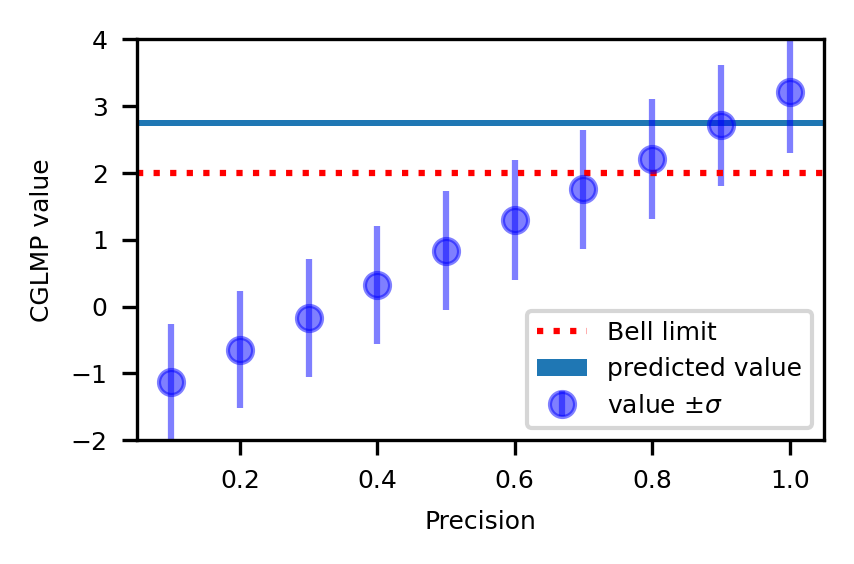

In [ ]:
num=10
Nantal=250000
target=df[:,-1]
acc=np.linspace(1.0,0.1,num)
lab=np.zeros(len(target))

idx=np.array(np.where(target == 0)[0])
idxHiggs=np.array(np.where(target == 1)[0])
np.random.shuffle(idx)
np.random.shuffle(idxHiggs)
lab[idxHiggs[:Nantal]]=1

fig,ax = plt.subplots(dpi=300)
phi1=np.extract(lab==1,df[:,12])
phi2=np.extract(lab==1,df[:,23])
bell=calcbell(phi1,phi2)
print(str(round(bell[0],2))+"+-"+str(round(np.sqrt(Nantal/423)*bell[1],2)))
s=6

for i in range(num-1):  
  phi1=np.extract(lab==1,df[:,12])
  phi2=np.extract(lab==1,df[:,23])
  bell=calcbell(phi1,phi2)
  plt.errorbar(acc[i], bell[0], np.sqrt(Nantal/423)*bell[1], fmt='o', alpha=0.5,color='blue')
  lab[idxHiggs[i*int(np.rint(Nantal/num)):(i+1)*int(np.rint(Nantal/num))]]=0
  lab[idx[i*int(np.rint(Nantal/num)):(i+1)*int(np.rint(Nantal/num))]]=1

phi1=np.extract(lab==1,df[:,12])
phi2=np.extract(lab==1,df[:,23])
bell=calcbell(phi1,phi2)

plt.errorbar(acc[-1], bell[0], np.sqrt(Nantal/423)*bell[1],fmt='o', alpha=0.5,color='blue', label='value $\pm \sigma$')
plt.hlines(2,acc[-1]-0.05,acc[0]+0.05,color='red', label='Bell limit', linestyle='dotted')
plt.fill_between(2*acc-0.5,2.7,2.8, label='predicted value')
plt.axis([0.05,1.05,-2,4])
plt.rcParams.update({'font.size' : 6})
plt.xlabel('Precision', fontsize=s)
plt.ylabel('CGLMP value', fontsize=s)
plt.legend(loc='lower right', fontsize=s)
plt.tight_layout()
fig.set_figwidth(2.5)
fig.set_figheight(1.5)
plt.show()

In [ ]:
print(len(target))

1411161
